<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_13_configuration_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок 13: Подготовка конфигураций для YOLO


## 1. Теория: Зачем нужна конфигурация в YOLO

Когда ты создаёшь собственную модель YOLO (You Only Look Once), особенно для кастомного датасета, необходимо подготовить:

- описание архитектуры модели (обычно `.yaml`)
- описание классов объектов
- путь к данным
- структура папок и формат аннотаций

YOLO нуждается в точном понимании **сколько классов**, **где находятся данные**, и **как устроено изображение** (размер, нормализация и пр.). Это всё задаётся в конфигурационных файлах.

Также ты можешь изменить архитектуру модели (например, сделать модель легче или глубже), указав нужные параметры в `.yaml` модели.

---



## 2. Нормализация: Что это и зачем

YOLO ожидает, что координаты bounding box'ов будут заданы в **нормализованном виде** — от 0 до 1 по ширине и высоте изображения. Это нужно для того, чтобы модель была **инвариантна к разрешению** изображения.

### Формула нормализации bounding box:

Пусть у нас:
- $x_{min}, y_{min}, x_{max}, y_{max}$ — координаты bbox в пикселях
- $W, H$ — ширина и высота изображения

Тогда YOLO-координаты будут:

$$
x = \frac{x_{min} + x_{max}}{2W}, \quad
y = \frac{y_{min} + y_{max}}{2H}, \quad
w = \frac{x_{max} - x_{min}}{W}, \quad
h = \frac{y_{max} - y_{min}}{H}
$$

### Пример:

```python
# Исходные координаты и размер изображения
x_min, y_min = 30, 40
x_max, y_max = 130, 140
W, H = 200, 200

# Нормализация
x_center = (x_min + x_max) / 2 / W
y_center = (y_min + y_max) / 2 / H
width = (x_max - x_min) / W
height = (y_max - y_min) / H

print(f"{x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}")
```

### Общая нормализация изображений:

Нормализация используется не только для координат, но и для **пикселей** — чаще всего их масштабируют в диапазон $[0, 1]$:

```python
img = img.astype('float32') / 255.0
```

Также можно использовать стандартизацию по среднему и стандартному отклонению (например, как в ImageNet).

---


Стандартизация по среднему и стандартному отклонению — это способ привести пиксельные значения изображения к "нормальному виду" с нулевым средним и единичной дисперсией. Это часто ускоряет обучение и повышает стабильность нейросетей.

📌 Что такое стандартизация?
Если у тебя есть изображение с пикселями $x$, стандартизация делается по формуле:

𝑥
𝑠
𝑡
𝑑
=
𝑥
−
𝜇
𝜎
x
std
​
 =
σ
x−μ
​

$x$ — оригинальные значения пикселей (0–255)

$\mu$ — среднее значение по каналу (mean)

$\sigma$ — стандартное отклонение по каналу (std)

📚 Пример: стандартизация как в ImageNet
Модель, обученная на ImageNet (например, ResNet, YOLOv5-cls и др.), обычно ожидает вход в следующем виде:

python
Копировать
Редактировать
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
💡 Почему такие значения?
Они рассчитаны по всей обучающей выборке ImageNet и позволяют привести входные данные к нулевому среднему с нормализованной дисперсией.

🧪 Как применить в коде:

import cv2
import numpy as np

# Загружаем изображение и переводим его в float32
img = cv2.imread('your_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # В [0, 1]

# Стандартизация по каналам
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# (H, W, C) → стандартизировать по каждому каналу
img_std = (img - mean) / std
Теперь img_std можно подавать на вход модели, обученной на ImageNet или аналогичной архитектуре.

In [3]:
import cv2
import numpy as np

# Загружаем изображение и переводим его в float32
img = cv2.imread('/content/foto2.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # В [0, 1]

# Стандартизация по каналам
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# (H, W, C) → стандартизировать по каждому каналу
img_std = (img - mean) / std
#Теперь img_std можно подавать на вход модели, обученной на ImageNet или аналогичной архитектуре.

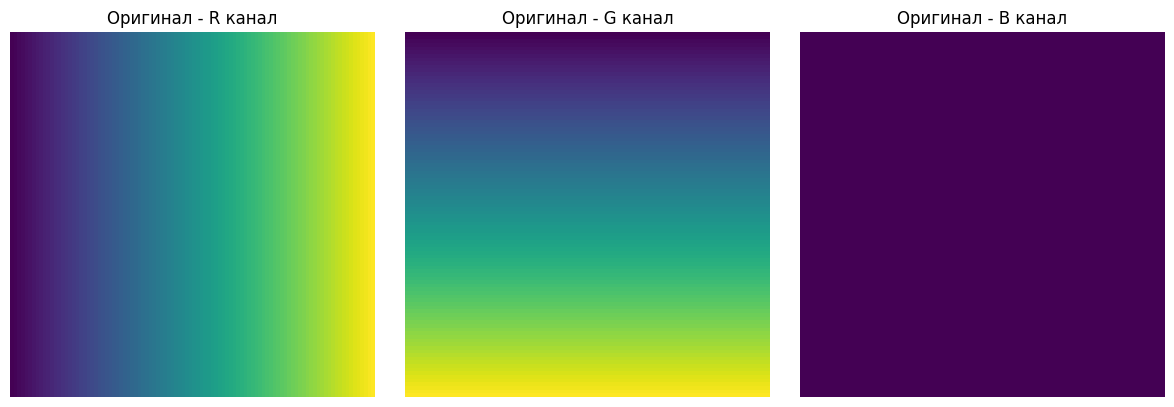

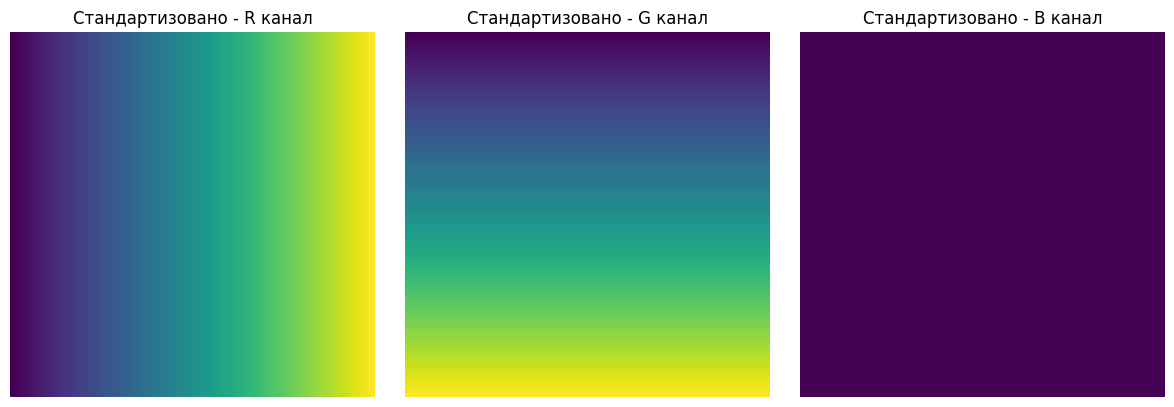

In [4]:
# Повторная инициализация после сброса
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Создадим фейковое RGB изображение (градиент)
H, W = 100, 100
r = np.tile(np.linspace(0, 1, W), (H, 1))        # красный канал — горизонтальный градиент
g = np.tile(np.linspace(0, 1, H), (W, 1)).T      # зелёный канал — вертикальный градиент
b = np.ones((H, W)) * 0.5                        # синий канал — просто 0.5

# Объединяем каналы в изображение
img = np.stack([r, g, b], axis=-1).astype(np.float32)

# Стандартизация по каналам (ImageNet)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_std = (img - mean) / std

# Функция для отображения отдельных каналов
def show_image_channels(img, title_prefix):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    channels = ['R', 'G', 'B']
    for i in range(3):
        axs[i].imshow(img[:, :, i], cmap='viridis')
        axs[i].set_title(f'{title_prefix} - {channels[i]} канал')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Покажем оригинальные и стандартизованные каналы
show_image_channels(img, 'Оригинал')
show_image_channels(img_std, 'Стандартизовано')



## 3. Подготовка dataset.yaml и структуры проекта

YOLOv5/v8 требует файл `dataset.yaml`, в котором указываются пути к данным и классы.

### Пример:

```yaml
train: ../data/images/train
val: ../data/images/val
test: ../data/images/test

nc: 3
names: ['car', 'person', 'bicycle']
```

- `nc` — количество классов
- `names` — список классов
- `train`, `val`, `test` — пути к изображениям (OpenCV читает их по этим путям)

### Структура проекта:

```
project/
├── images/
│   ├── train/
│   ├── val/
│   └── test/
└── labels/
    ├── train/
    ├── val/
    └── test/
```

Формат `.txt` аннотаций:

```
<class_id> <x_center> <y_center> <width> <height>
```

### Пример аннотации:

```
0 0.524 0.512 0.300 0.200
1 0.200 0.400 0.150 0.250
```

Это значит:
- Класс 0 (например, "car") находится примерно в центре изображения
- Размеры — 30% по ширине, 20% по высоте

### Верификация аннотаций (OpenCV):

Так можно визуально проверить аннотацию.

---


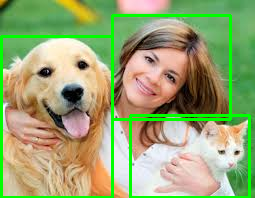

In [6]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/foto2.jpeg')
h, w = image.shape[:2]

with open('/content/foto2.txt') as f:
    for line in f:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2_imshow(image)



## 4. Упражнение по линейной алгебре — Формирование анатомически реалистичного движения

В компьютерном зрении часто нужно моделировать движения человека или объекта, например — для анимации, распознавания поз или имитации действий.

### Математическая модель:

Представим, что мы хотим смоделировать движение руки как вращение вокруг сустава.

#### Матрица вращения в 2D:

Для угла $\theta$:

$$
R(\theta) =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}
$$

#### Перемещение точки:

Если начальная точка $\vec{p} = [x, y]^T$, после вращения:

$$
\vec{p}' = R(\theta) \cdot \vec{p}
$$

### Пример (Python + NumPy):




In [7]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.radians(45)
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

p = np.array([1, 0])  # Исходная точка на оси X
p_rot = R @ p

print("Исходная точка:", p)
print("После вращения:", p_rot)

Исходная точка: [1 0]
После вращения: [0.70710678 0.70710678]


## 5. Практика OpenCV — Применение трансформации

Так мы визуализируем вращение точки вокруг центра — важно для реалистичных движений в позах, костях, суставных ограничениях и т.п.


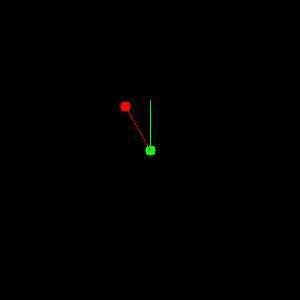

In [12]:
import cv2
import numpy as np

# Создаём изображение
img = np.zeros((300, 300, 3), dtype=np.uint8)
cv2.circle(img, (150, 150), 5, (0, 255, 0), -1)

# Вращаем точку (150, 100) вокруг центра (150, 150)
angle = 30
M = cv2.getRotationMatrix2D((150, 150), angle, 1)
point = np.array([[150, 100]], dtype=np.float32)
point = np.array([point])
rotated_point = cv2.transform(point, M)

x, y = rotated_point[0][0]
cv2.circle(img, (int(x), int(y)), 5, (0, 0, 255), -1)

cv2.line(img, (150, 150), (150, 100), (0, 255, 0), 1)
cv2.line(img, (150, 150), (int(x), int(y)), (0, 0, 255), 1)

cv2_imshow(img)
